<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Статистическая-проверка-гипотез" data-toc-modified-id="Статистическая-проверка-гипотез-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Статистическая проверка гипотез</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение перспективного тарифа для телеком-оператора

Целью данного исследования является сравнение и анализ клиентских тарифов телеком-оператора. Чтобы скорректировать рекламный бюджет, необходимо понять, какой тариф приносит больше денег.

Для анализа имеются данные по небольшой выборке клиентов:
 - информация о пользователях
 - информация о тарифах
 - информация о звонках
 - информация о сообщениях
 - информация об интернет-сессиях
 
Необходимо проверить гипотезы:
 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
 


## Загрузка и предобработка данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import math
from scipy import stats as st
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.float_format', '{:,.2f}'.format)

Загрузим файлы с данными о пользователях, звонках, сообщениях, интернет-сессиях и тарифах и сохраним их в переменные `users`, `calls`, `messages`, `internet` и `tariffs`. Выведем на экран первые 5 строк таблиц:

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
tariffs = pd.read_csv('/datasets/tariffs.csv')

display(users.head())
display(calls.head())
display(messages.head())
display(internet.head())
display(tariffs.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Согласно документации к данным:

Таблица **`users`** (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица **`calls`** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица **`messages`** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица **`internet`** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица **`tariffs`** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Изучим общую информацию о таблицах:

In [3]:
tables = [users, calls, messages, internet, tariffs]

for i in tables:
    i.info()
    print('\n' * 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB



<class 'pandas.core.f

Заменим тип данных в столбцах с датой с текстового на `datetime`:

In [4]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

Проверим наличие явных дубликатов в таблицах:

In [5]:
table_name = ['users', 'calls', 'messages', 'internet', 'tariffs']
j=-1

for i in tables:
    j +=1
    print('Количество дубликатов в', table_name[j],':', i.duplicated().sum())

Количество дубликатов в users : 0
Количество дубликатов в calls : 0
Количество дубликатов в messages : 0
Количество дубликатов в internet : 0
Количество дубликатов в tariffs : 0


Явные дубликаты в таблицах не обнаружены. 

Проверим наличие пропусков в таблицах:

In [6]:
j=-1
for i in tables:
    j +=1
    print('Количество пропусков в таблице', table_name[j],':\n', round(i.isna().mean(), 2), '\n')

Количество пропусков в таблице users :
 user_id      0.00
age          0.00
churn_date   0.92
city         0.00
first_name   0.00
last_name    0.00
reg_date     0.00
tariff       0.00
dtype: float64 

Количество пропусков в таблице calls :
 id          0.00
call_date   0.00
duration    0.00
user_id     0.00
dtype: float64 

Количество пропусков в таблице messages :
 id             0.00
message_date   0.00
user_id        0.00
dtype: float64 

Количество пропусков в таблице internet :
 id             0.00
mb_used        0.00
session_date   0.00
user_id        0.00
dtype: float64 

Количество пропусков в таблице tariffs :
 messages_included       0.00
mb_per_month_included   0.00
minutes_included        0.00
rub_monthly_fee         0.00
rub_per_gb              0.00
rub_per_message         0.00
rub_per_minute          0.00
tariff_name             0.00
dtype: float64 



В столбце `churn_date` присутствует значительное количество пропусков, но согласно документации к данным, если значение в данном поле пропущено, то тариф ещё действовал на момент выгрузки, поэтому наличие данных пропусков не является ошибкой.

## Исследовательский анализ данных

Объединим данные о тарифах, звонках, сообщениях и интернет-сессиях в единый датафрейм и сгруппируем его помесячно. 

Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно, а для веб-трафика отдельные сессии не считаются. Округлим длительность звонков согласно тарифам:

In [7]:
calls['duration_rounded'] = calls['duration'].apply(lambda x: math.ceil(x))

Добавим столбец с месяцем:

In [8]:
calls['month'] = calls['call_date'].dt.strftime('%Y-%m')
messages['month'] = messages['message_date'].dt.strftime('%Y-%m')
internet['month'] = internet['session_date'].dt.strftime('%Y-%m')

Далее сгруппируем данные по месяцу и `user_id`:

In [9]:
calls_grouped = calls.groupby(['month', 'user_id'])['duration_rounded'].sum().reset_index()
messages_grouped = messages.groupby(['month', 'user_id'])['id'].count().reset_index().rename(columns={'id':'message_count'})
internet_grouped = internet.groupby(['month', 'user_id'])['mb_used'].sum().reset_index()

Объединим датафреймы по полю `user_id` и `month`:

In [10]:
dfs = [calls_grouped, messages_grouped, internet_grouped]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'month'], how='outer'), dfs).fillna(0)

Обогатим полученный датафрейм данными о пользователе и тарифе:

In [11]:
df_merged = df_merged.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='left')
df_merged = df_merged.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left').drop(columns=['tariff_name'])

Добавим информацию о перерасходе услуг:

In [12]:
# перерасход минут
df_merged['minutes_extra'] = (df_merged['duration_rounded'] - df_merged['minutes_included']).clip(lower=0)

# перерасход сообщений
df_merged['messages_extra'] = (df_merged['message_count'] - df_merged['messages_included']).clip(lower=0)

# перерасход трафика и округление вверх
df_merged['gb_extra'] = (df_merged['mb_used'] - df_merged['mb_per_month_included']
                        ).apply(lambda x: math.ceil(x / 1024)).clip(lower=0)

Добавим информацию о выручке по пользователю с учетом перерасхода услуг, включенных в тариф:

In [13]:
df_merged['revenue'] = (
    df_merged['rub_monthly_fee']
    + df_merged['rub_per_minute'] * df_merged['minutes_extra']
    + df_merged['rub_per_message'] * df_merged['messages_extra']
    + df_merged['rub_per_gb'] * df_merged['gb_extra']
)

Добавим информацию об объеме использованного интернет-трафика в Гб:

In [14]:
df_merged['gb_used'] = df_merged['mb_used'] / 1024

Проверим корректность объединения датафреймов:

In [15]:
print(calls['duration_rounded'].sum().round(0).astype('float'), '— длительность звонков в исходном датафрейме')
print(df_merged['duration_rounded'].sum().round(0), '— длительность звонков в объединенном датафрейме')
print('\n')

print(messages['id'].count().astype('float'), '— количество сообщений в исходном датафрейме')
print(df_merged['message_count'].sum(), '— количество сообщений в объединенном датафрейме')
print('\n')

print(internet['mb_used'].sum().round(0), '— объем интернет-трафика в исходном датафрейме')
print(df_merged['mb_used'].sum().round(0), '— объем интернет-трафика в объединенном датафрейме')

1450301.0 — длительность звонков в исходном датафрейме
1450301.0 — длительность звонков в объединенном датафрейме


123036.0 — количество сообщений в исходном датафрейме
123036.0 — количество сообщений в объединенном датафрейме


55305268.0 — объем интернет-трафика в исходном датафрейме
55305268.0 — объем интернет-трафика в объединенном датафрейме


Данные объединены корректно.

Изучим распределение длительности звонков, количества сообщений и объема интернет-трафика в разрезе тарифов:

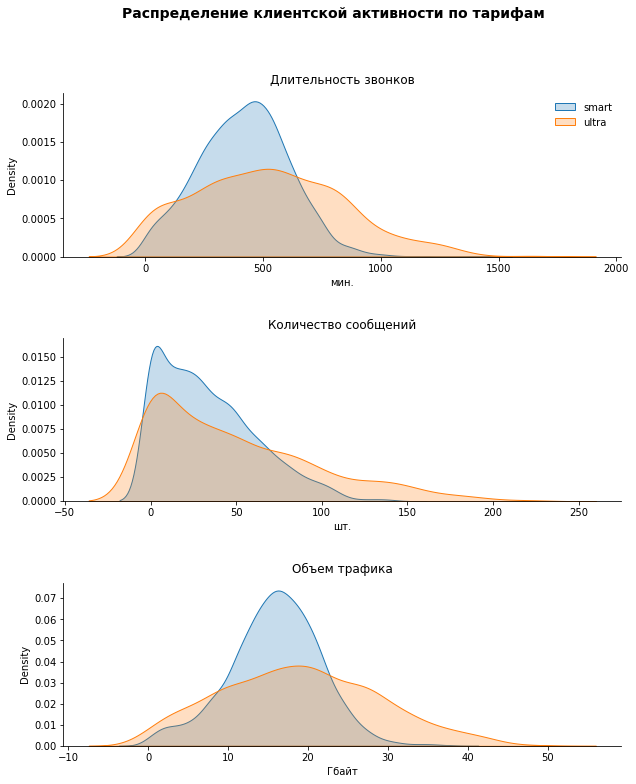

In [16]:
columns=['duration_rounded', 'message_count', 'gb_used']
title={'duration_rounded':'Длительность звонков', 'message_count':'Количество сообщений', 'gb_used':'Объем трафика'}
unit={'duration_rounded':'мин.', 'message_count':'шт.', 'gb_used':'Гбайт'}

plt.figure(figsize=(10, 12))
plt.suptitle('Распределение клиентской активности по тарифам', fontsize=14, fontweight='bold')     

counter = 0
for column in columns:
    counter += 1
    for tariff in df_merged['tariff'].unique():
        plt.subplot(3, 1, counter)
        plt.subplots_adjust(hspace=0.5)
        sns.kdeplot(df_merged.query('tariff == @tariff')[column], label=tariff, shade=True)
        plt.xlabel(unit[column])
        plt.title(title[column], pad=10)
        sns.despine()
plt.legend(bbox_to_anchor=[1, 4], frameon=False)
plt.show()

Из распределений видно, что данные пользователей тарифа «Смарт» имеют более выраженный пик значений и меньшую дисперсию.

Изучим описательную статистику по клиентской активности в разрезе тарифов:

In [17]:
# функция для расчета дисперсии:
def var(x):
    return np.var(x, ddof=1)

# функция для расчета стандартного отклонения:
def std(x):
    return np.std(x, ddof=1)

# сформируем датафрейм с описательной статистикой:
df_merged.pivot_table(index='tariff', values=['duration_rounded', 'message_count', 'gb_used', 'revenue'], 
                      aggfunc=['mean', var, std]).T

tariff                     smart      ultra
mean duration_rounded     417.93     526.62
     gb_used               15.83      19.01
     message_count         33.38      49.36
     revenue            1,289.97   2,070.15
var  duration_rounded  36,219.32 100,873.63
     gb_used               32.87      97.04
     message_count        796.81   2,285.27
     revenue          669,785.71 141,516.75
std  duration_rounded     190.31     317.61
     gb_used                5.73       9.85
     message_count         28.23      47.80
     revenue              818.40     376.19

 Пользователи тарифа «Ультра» активней пользуются услугами связи и обладают более выской средней выручкой.

## Статистическая проверка гипотез

Построим график распределения плотности вероятности средней выручки пользователей тарифов «Ультра» и «Смарт»:

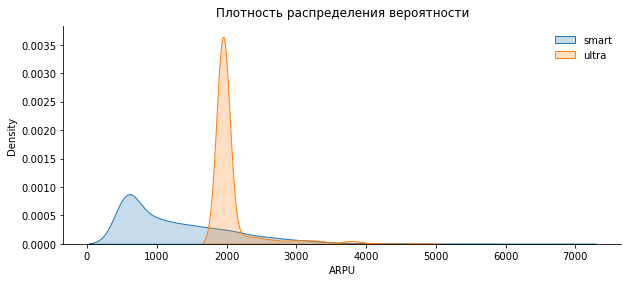

In [18]:
# зададим переменные:
smart = df_merged[df_merged['tariff'] == 'smart']['revenue']
ultra = df_merged[df_merged['tariff'] == 'ultra']['revenue']

plt.figure(figsize=(10, 4))
sns.kdeplot(smart, label='smart', shade=True)
sns.kdeplot(ultra, label='ultra', shade=True)
plt.title('Плотность распределения вероятности', pad=10)
plt.xlabel('ARPU')
plt.legend(frameon=False)
sns.despine()

Из распределения видно, что выручка пользователей тарифа «Ультра» выше, чем пользователей тарифа «Смарт».
Для оценки статистической значимости данного различия проверим гипотезу о различии средней выручки пользователей тарифов «Ультра» и «Смарт».
Сформулируем нулевую гипотезу $H_{0}$: различие в выручке между тарифами «Ультра» и «Смарт» отсутствует. Тогда альтернативная гипотеза $H_{1}$ будет звучать как: различие в выручке между тарифами «Ультра» и «Смарт» статистически значимо. Для проверки гипотезы о равенстве средних двух генеральных совокупностей применим t-тест для независимых выборок:

In [19]:
# определим критический уровень статистической значимости:
alpha = 0.05

# применим t-тест:
test = st.ttest_ind(smart, ultra, equal_var = False)

print('p-value:', test.pvalue)

if test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Проверка гипотезы показала, что различие средней выручки пользователей тарифов «Ультра» и «Смарт» статистически значимо, выручка пользователей тарифа «Ультра» выше.

Построим график распределения плотности вероятности средней выручки пользователей из Москвы и пользователей из других регионов в разрезе тарифов:

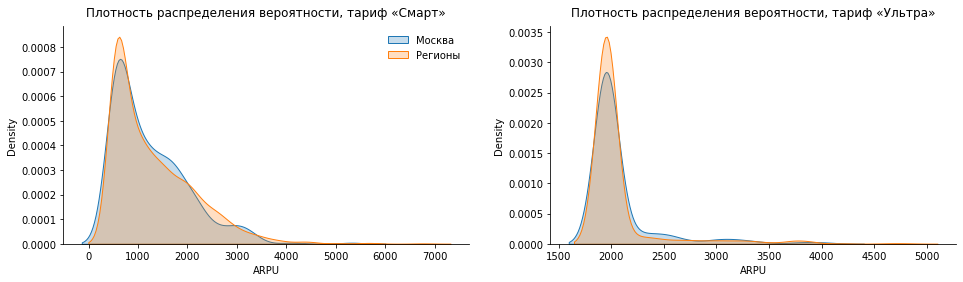

In [20]:
# зададим переменные:
moscow = df_merged[df_merged['city'] == 'Москва']['revenue']
regions = df_merged[df_merged['city'] != 'Москва']['revenue']

moscow_smart = df_merged[(df_merged['city'] == 'Москва') & (df_merged['tariff'] == 'smart')]['revenue']
regions_smart = df_merged[(df_merged['city'] != 'Москва') & (df_merged['tariff'] == 'smart')]['revenue']
moscow_ultra = df_merged[(df_merged['city'] == 'Москва') & (df_merged['tariff'] == 'ultra')]['revenue']
regions_ultra = df_merged[(df_merged['city'] != 'Москва') & (df_merged['tariff'] == 'ultra')]['revenue']

# тариф «Смарт»
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(moscow_smart, label='Москва', shade=True)
sns.kdeplot(regions_smart, label='Регионы', shade=True)
plt.title('Плотность распределения вероятности, тариф «Смарт»', pad=10)
plt.xlabel('ARPU')
plt.legend(frameon=False)

# тариф «Ультра»
plt.subplot(1, 2, 2)
sns.kdeplot(moscow_ultra, label='Москва', shade=True)
sns.kdeplot(regions_ultra, label='Регионы', shade=True)
plt.title('Плотность распределения вероятности, тариф «Ультра»', pad=10)
plt.xlabel('ARPU')
plt.legend('', frameon=False) 

sns.despine()
plt.show()

Распределение выручки для пользователей из Москвы и пользователей из других регионов является сопоставимым. Аналогично проверим гипотезу о различии средней выручки пользователей из Москвы и пользователей из других регионов. Сформулируем нулевую гипотезу  $H_{0}$: различие в выручке между пользователями из Москвы и пользователями из других регионов отсутствует. Тогда альтернативная гипотеза  $H_{1}$ будет звучать как: различие в выручке между пользователями из Москвы и пользователями из других регионов статистически значимо. Для проверки гипотезы о равенстве средних двух генеральных совокупностей применим t-тест для независимых выборок:

In [21]:
# определим критический уровень статистической значимости:
alpha = 0.05

# применим t-тест:
test = st.ttest_ind(moscow, regions)

print('p-value:', test.pvalue)

if test.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Проверка гипотезы показала, что статистически значимое различие средней выручки пользователей из Москвы и пользователей из других регионов отсутствует.

Рассмотрим суммарную выручку по тарифам:

In [22]:
revenue_total = df_merged.pivot_table(index='tariff', values='revenue', aggfunc=['sum'])
clients_cnt = df_merged.pivot_table(index='tariff', values='user_id', aggfunc=['nunique'])

report = revenue_total.join(clients_cnt).reset_index()
report.columns = ['Тариф', 'Выручка', 'Кол-во клиентов']
display(report)

,Тариф,Выручка,Кол-во клиентов
0,smart,"2,875,351.00",350
1,ultra,"2,039,100.00",148


Тариф «Смарт» принес оператору больше выручки, т.к. им пользуются в 2.4 раза больше клиентов, чем тарифом «Ультра».

## Общий вывод

На основании проведенного анализа мы выяснили, что пользователи тарифа «Ультра» более активно пользуются услугами оператора и обладают более высокой средней выручкой на одного пользователя (ARPU). Статистически значимое различие между средней выручкой пользователей из Москвы и пользователей из других регионов отсутствует. Тариф «Смарт» приносит оператору больше выручки, но для целей максимизации прибыли рекомендуется усилить рекламную кампанию тарифа «Ультра» по всей стране.